# Neural Networks

In [54]:
from time import time
from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import quantile_transform

from tensorflow.keras.layers import Input, Dense, Dot, BatchNormalization
from tensorflow.keras.models import Model

In [2]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(
        self,
        n_splits=3,
        train_period_length=126,
        test_period_length=21,
        lookahead=0,
        date_idx="date",
        shuffle=False,
    ):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append(
                [train_start_idx, train_end_idx, test_start_idx, test_end_idx]
            )

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[
                (dates[self.date_idx] > days[train_start])
                & (dates[self.date_idx] <= days[train_end])
            ].index
            test_idx = dates[
                (dates[self.date_idx] > days[test_start])
                & (dates[self.date_idx] <= days[test_end])
            ].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self):
        return self.n_splits


In [3]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

In [4]:
def cache(func):
    def wrapped_func(*args, **kwargs):
        table_name = func.__name__.split("_")[-1]
        parquet_path = f"./data/{table_name}.parquet"
        try:
            table = pd.read_parquet(parquet_path)
        except FileNotFoundError:
            table = func(*args, **kwargs)
            table.to_parquet(parquet_path)
        return table

    return wrapped_func

def query(sql_stmt, params, wrds_username):
    import wrds

    with wrds.Connection(wrds_username=wrds_username) as db:
        data = db.raw_sql(sql_stmt, date_cols=["date"], params=params)
    return data

def get_crsp(permnos, wrds_username):
    sql_crsp = """
    SELECT
        date,
        permno,
        openprc AS open,
        askhi AS high,
        bidlo AS low,
        prc AS close,
        vol AS volume,
        ret,
        shrout
    FROM
        crsp.dsf
    WHERE
        permno IN %(permnos)s
        AND date >= '1994-01-01'
        AND date <= '2019-12-31'
    ORDER BY
        date, permno;
    """
    params = {"permnos": permnos}
    crsp = query(sql_crsp, params, wrds_username)
    # Fill missing close prices of permno 80539
    crsp.loc[crsp.permno == 80539, "close"] = crsp.loc[crsp.permno == 80539, "close"].fillna(method="ffill")
    # Fill other missing values
    crsp = crsp.fillna({"open": crsp.close,
        "high": crsp.close,
        "low": crsp.close,
        "volume": 0,
        "ret": 0})
    # Calculate market capitalization
    crsp["cap"] = crsp.close * crsp.shrout
    # Shift market capitalization to avoid look ahead bias
    crsp["cap"] = crsp.groupby("permno").cap.shift(1)
    # Calculate market capiticalization weight
    crsp["w_cap"] = crsp.groupby("date").cap.apply(lambda x: x / x.sum())
    # Convert certain data types to int64
    crsp = crsp.astype({"permno":"int",
                        "shrout": "int",
                        "volume":"int"})
    return crsp

def get_fama_french():
    """
    Get 3-factor and momentum data from Ken French data library.
    """
    import pandas_datareader as web

    # Transfrom from percentage to nominal value
    factor = web.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start="1994-01-01", end="2019-12-31")[0]/100
    momentum = web.DataReader("F-F_Momentum_Factor_daily", "famafrench", start="1994-01-01", end="2019-12-31")[0]/100
    # Merge into 4 factor model
    fama_french = pd.concat([factor, momentum], axis=1)
    fama_french = fama_french.rename(columns=lambda x: x.lower().strip().replace("-", "")).rename_axis(index=str.lower)
    return fama_french

In [5]:
path = Path("./data")
permno_path = path/"permno_selection.csv"
permnos = pd.read_csv(permno_path, dtype={"permno":"str"}).squeeze().pipe(tuple)
crsp = get_crsp(permnos, "iewaij")
fama_french = get_fama_french()

Loading library list...
Done


## Estimate Factor Exposure

In [6]:
portfolio = crsp.loc[crsp.date >= "1994-01-01", ["date", "permno", "ret"]].pivot(
    index="date", columns="permno", values="ret"
)
portfolio = portfolio.sub(fama_french.loc[portfolio.index, "rf"], axis=0)
factor = fama_french.loc[portfolio.index, ["mktrf", "smb", "hml", "mom"]].assign(alpha=1)
betas = []
for permno in portfolio:
    ret = portfolio[permno]
    res = RollingOLS(endog=ret, exog=factor, window=756).fit(params_only=True)
    params = res.params
    params["resid"] = ret - factor.mul(params).sum(1)
    params["excess"] = ret - factor.mktrf * params.mktrf
    params["permno"] = permno
    betas.append(params)
beta = pd.concat(betas).reset_index().dropna()

## Estimate Price Trend

In [7]:
ret = crsp.pivot(index="date", columns="permno", values="ret")
logret = np.log(ret+1)
# 1-month cumulative return
mom_1m = logret.rolling(21).sum()
# 11-month cumulative returns ending 1-month before
mom_12m = logret.shift(21).rolling(11*21).sum()
# Cumulative return from months t-6 to t-1 minus months t-12 to t-7.
mom_6m = logret.shift(21).rolling(5*21).sum()
mom_12m_6m = logret.shift(6*21).rolling(5*21).sum()
chmom = mom_6m - mom_12m_6m
# Max daily returns from calendar month t-1
maxret = logret.rolling(21).max()
# Cumulative returns months t-36 to t-13
mom_36m = logret.shift(12*21).rolling(24*21).sum()

## Estimate Liquidity

In [8]:
vol = crsp.pivot(index="date", columns="permno", values="volume")
shrout = crsp.pivot(index="date", columns="permno", values="shrout")
close = crsp.pivot(index="date", columns="permno", values="close") 
# Average monthly trading volume for most recent three months divided by number of shares
turn = vol.shift(21).mean().div(shrout)
# Monthly std dev of daily share turnover
turn_std = vol.div(shrout).rolling(21).std()
# Natural log of market cap
logcap = np.log(close) + np.log(shrout)
# Natural log of trading volume times price per share from month t-2
dv = vol.mul(close)
dolvol = np.log(dv.shift(21).rolling(21).mean())
# Average of daily (absolute return / dollar volume)
ill = ret.abs().div(dv)

/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


## Estimate Risk

In [9]:
# Standard dev of daily returns from month t-1
retvol = ret.rolling(21).std()
# Market beta
mktrf = beta.pivot(index="date", columns="permno", values="mktrf")
# Market beta squared
mktrf_sq = mktrf.pow(2)
# Idiosyncratic return volatility
resid = beta.pivot(index="date", columns="permno", values="resid")
idovol = resid.rolling(756).std()

## Prepare Data

In [39]:
def combine_factor(**kwargs):
    from sklearn.preprocessing import quantile_transform

    characteristics = [
        "mom_1m",
        "mom_12m",
        "chmom",
        "maxret",
        "mom_36m",
        "turn",
        "turn_std",
        "logcap",
        "dolvol",
        "ill",
        "retvol",
        "mktrf",
        "mktrf_sq",
        "idovol",
    ]

    factor = pd.DataFrame(
        {
            name: factor.resample("W-FRI").last().stack()
            for name, factor in kwargs.items()
        }
    ).loc["2000-01-01":]

    factor.loc[:, characteristics] = (
        factor.loc[:, characteristics]
        .groupby("date")
        .apply(
            lambda x: pd.DataFrame(
                quantile_transform(x, copy=True, n_quantiles=x.shape[0]),
                columns=characteristics,
                index=x.index.get_level_values("permno"),
            )
        )
        .mul(2)
        .sub(1)
    )
    factor = factor.groupby("date").transform(lambda x: x.fillna(x.mean()))
    return factor


In [40]:
factor = combine_factor(
    mom_1m=mom_1m,
    mom_12m=mom_12m,
    chmom=chmom,
    maxret=maxret,
    mom_36m=mom_36m,
    turn=turn,
    turn_std=turn_std,
    logcap=logcap,
    dolvol=dolvol,
    ill=ill,
    retvol=retvol,
    mktrf=mktrf,
    mktrf_sq=mktrf_sq,
    idovol=idovol,
    ret=ret
)
ret_5d = np.exp(logret.resample("W-FRI").sum().stack().shift(-1)) - 1
X = factor["2000-01-01":"2012-12-31"] 
y = ret_5d["2000-01-01":"2012-12-31"]

In [27]:
n_characteristics = 14
n_tickers = 50

In [41]:
def make_model(hidden_units, n_factors):
    input_factor = Input((n_tickers,), name='input_factor')
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)
    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)
    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])
    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

In [42]:
def get_train_valid_data(X, y, train_idx, val_idx):
    X_train = X.iloc[train_idx]
    X_val = X.iloc[val_idx]
    X1_train = X_train.drop(columns="ret").to_numpy().reshape(-1, n_tickers, n_characteristics)
    X1_val = X_val.drop(columns="ret").to_numpy().reshape(-1, n_tickers, n_characteristics)
    X2_train = X_train.loc[:, "ret"].unstack("permno")
    X2_val = X_val.loc[:, "ret"].unstack("permno")
    y_train = y.iloc[train_idx].unstack("permno")
    y_val = y.iloc[val_idx].unstack("permno")
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

In [46]:
cv = MultipleTimeSeriesCV(n_splits=3,
                          train_period_length=6*52,
                          test_period_length=1*52)

In [47]:
factor_opts = [4, 6, 10]
unit_opts = [8, 16, 32]
param_grid = list(product(unit_opts, factor_opts))
batch_size = 32
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [48]:
start = time()
for units, n_factors in param_grid:
    scores = []
    model = make_model(hidden_units=units, n_factors=n_factors)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(X, y,
                                                                                  train_idx,
                                                                                  val_idx)
        for epoch in range(250):
            model.fit([X1_train, X2_train], y_train,
                      batch_size=batch_size,
                      validation_data=([X1_val, X2_val], y_val),
                      epochs=epoch + 1,
                      initial_epoch=epoch,
                      verbose=0, shuffle=True)
            result = (pd.DataFrame({'y_pred': model.predict([X1_val,
                                                             X2_val]).reshape(-1),
                                    'y_true': y_val.stack().values},
                                   index=y_val.stack().index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')            
    scores = pd.DataFrame(scores, columns=cols)
    scores.to_hdf('./scores.h5', f'{units}/{n_factors}')

2022-03-28 23:18:10.262411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:18:11.102451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:18:11.237332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:00:01 | 4 | 08 | 00-000 | -5.77% |  3.22% |  2.12%
00:00:14 | 4 | 08 | 00-050 | 17.58% |  3.75% |  3.20%
00:00:26 | 4 | 08 | 00-100 | 19.33% |  2.81% |  1.28%
00:00:37 | 4 | 08 | 00-150 | 18.08% |  2.42% |  1.24%
00:00:49 | 4 | 08 | 00-200 | 17.72% |  3.03% |  2.30%
00:01:00 | 4 | 08 | 01-000 | 24.62% |  3.74% |  4.88%
00:01:12 | 4 | 08 | 01-050 | 16.20% |  1.78% |  4.02%
00:01:23 | 4 | 08 | 01-100 | 14.74% |  0.99% |  3.28%
00:01:34 | 4 | 08 | 01-150 | 12.10% |  0.51% |  2.30%
00:01:45 | 4 | 08 | 01-200 | 11.58% |  1.76% |  3.85%
00:01:57 | 4 | 08 | 02-000 | 28.83% |  7.85% |  8.96%
00:02:08 | 4 | 08 | 02-050 | 26.70% |  6.19% |  7.77%
00:02:19 | 4 | 08 | 02-100 | 25.87% |  5.85% |  6.27%
00:02:30 | 4 | 08 | 02-150 | 25.54% |  5.46% |  5.60%
00:02:42 | 4 | 08 | 02-200 | 25.07% |  5.12% |  6.02%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
2022-03-28 23:21:03.096542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:21:03.425490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:21:03.552324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:02:54 | 6 | 08 | 00-000 |  7.07% | -0.74% | -2.18%
00:03:05 | 6 | 08 | 00-050 | 12.33% | -2.37% | -2.02%
00:03:16 | 6 | 08 | 00-100 | 16.53% | -0.48% |  0.50%
00:03:28 | 6 | 08 | 00-150 | 16.22% |  1.61% |  1.08%
00:03:39 | 6 | 08 | 00-200 | 15.48% |  1.87% |  0.42%
00:03:51 | 6 | 08 | 01-000 | 25.65% |  5.71% |  4.93%
00:04:02 | 6 | 08 | 01-050 | 17.46% |  4.41% |  2.31%
00:04:13 | 6 | 08 | 01-100 | 15.00% |  4.72% |  2.67%
00:04:25 | 6 | 08 | 01-150 | 14.18% |  5.20% |  4.35%
00:04:36 | 6 | 08 | 01-200 | 12.86% |  5.11% |  3.71%
00:04:48 | 6 | 08 | 02-000 | 33.12% | 11.43% |  9.09%
00:04:60 | 6 | 08 | 02-050 | 27.92% | 10.08% |  8.92%
00:05:11 | 6 | 08 | 02-100 | 27.42% | 10.05% |  8.53%
00:05:22 | 6 | 08 | 02-150 | 25.97% | 10.45% |  9.04%
00:05:34 | 6 | 08 | 02-200 | 24.34% |  9.28% |  6.08%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
2022-03-28 23:23:56.012636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:23:57.115259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:23:57.258773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:05:47 | 10 | 08 | 00-000 | -6.78% | -1.29% | -0.49%
00:05:60 | 10 | 08 | 00-050 | 17.26% |  1.96% |  3.03%
00:06:12 | 10 | 08 | 00-100 | 19.33% |  2.23% |  3.06%
00:06:23 | 10 | 08 | 00-150 | 19.83% |  2.58% |  3.05%
00:06:35 | 10 | 08 | 00-200 | 19.57% |  2.25% |  3.10%
00:06:47 | 10 | 08 | 01-000 | 25.55% |  8.18% |  7.11%
00:06:59 | 10 | 08 | 01-050 | 16.39% |  6.19% |  6.00%
00:07:11 | 10 | 08 | 01-100 | 14.65% |  4.84% |  4.61%
00:07:23 | 10 | 08 | 01-150 | 12.07% |  5.20% |  4.00%
00:07:35 | 10 | 08 | 01-200 | 11.82% |  4.71% |  5.60%
00:07:47 | 10 | 08 | 02-000 | 32.52% | 14.24% | 13.65%
00:07:58 | 10 | 08 | 02-050 | 27.81% |  9.85% | 11.77%
00:08:11 | 10 | 08 | 02-100 | 26.52% |  9.47% | 11.36%
00:08:22 | 10 | 08 | 02-150 | 24.70% |  9.20% | 13.36%
00:08:34 | 10 | 08 | 02-200 | 24.22% |  7.92% | 12.01%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
2022-03-28 23:26:55.293671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:26:56.098718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:26:56.232090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:08:46 | 4 | 16 | 00-000 | -15.22% | -0.77% |  0.43%
00:08:58 | 4 | 16 | 00-050 | 17.37% |  0.27% |  1.24%
00:09:09 | 4 | 16 | 00-100 | 21.20% |  1.50% |  1.60%
00:09:20 | 4 | 16 | 00-150 | 20.38% |  1.05% |  1.83%
00:09:31 | 4 | 16 | 00-200 | 18.66% |  0.28% |  1.99%
00:09:43 | 4 | 16 | 01-000 | 24.93% |  9.92% |  9.66%
00:09:54 | 4 | 16 | 01-050 | 17.82% |  8.23% |  6.81%
00:10:05 | 4 | 16 | 01-100 | 15.40% |  7.86% |  8.56%
00:10:17 | 4 | 16 | 01-150 | 13.76% |  6.87% |  8.21%
00:10:28 | 4 | 16 | 01-200 | 12.74% |  6.66% |  8.52%
00:10:40 | 4 | 16 | 02-000 | 30.16% | 10.70% |  9.72%
00:10:51 | 4 | 16 | 02-050 | 28.30% |  8.88% |  7.98%
00:11:03 | 4 | 16 | 02-100 | 26.82% |  7.97% |  6.51%
00:11:15 | 4 | 16 | 02-150 | 25.81% |  7.40% |  4.72%
00:11:27 | 4 | 16 | 02-200 | 24.87% |  7.26% |  5.85%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
2022-03-28 23:29:48.348405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:29:48.709185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:29:48.839696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:11:39 | 6 | 16 | 00-000 | -0.96% |  1.49% |  2.46%
00:11:51 | 6 | 16 | 00-050 | 14.15% |  6.52% |  6.83%
00:12:02 | 6 | 16 | 00-100 | 15.49% |  6.57% |  7.96%
00:12:13 | 6 | 16 | 00-150 | 14.20% |  5.84% |  8.84%
00:12:24 | 6 | 16 | 00-200 | 13.94% |  5.52% |  7.50%
00:12:36 | 6 | 16 | 01-000 | 26.70% |  8.08% |  6.14%
00:12:47 | 6 | 16 | 01-050 | 19.50% |  6.35% |  5.95%
00:12:58 | 6 | 16 | 01-100 | 17.16% |  6.58% |  4.75%
00:13:10 | 6 | 16 | 01-150 | 16.06% |  7.28% |  4.58%
00:13:21 | 6 | 16 | 01-200 | 15.71% |  7.67% |  6.72%
00:13:32 | 6 | 16 | 02-000 | 32.81% | 14.51% | 16.23%
00:13:44 | 6 | 16 | 02-050 | 28.38% | 11.92% | 14.10%
00:13:55 | 6 | 16 | 02-100 | 26.85% | 11.21% | 13.90%
00:14:08 | 6 | 16 | 02-150 | 25.64% | 10.85% | 14.16%
00:14:19 | 6 | 16 | 02-200 | 25.50% | 10.46% | 12.82%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
2022-03-28 23:32:41.180106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:32:41.588638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:32:41.732884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:14:32 | 10 | 16 | 00-000 | 14.32% |  1.43% | -0.10%
00:14:44 | 10 | 16 | 00-050 | 15.74% |  1.76% |  0.37%
00:14:55 | 10 | 16 | 00-100 | 16.81% |  1.94% |  1.34%
00:15:07 | 10 | 16 | 00-150 | 17.19% |  3.15% |  3.98%
00:15:19 | 10 | 16 | 00-200 | 16.88% |  2.84% |  3.89%
00:15:30 | 10 | 16 | 01-000 | 27.41% | 10.13% | 12.25%
00:15:42 | 10 | 16 | 01-050 | 19.47% |  8.86% | 12.04%
00:15:54 | 10 | 16 | 01-100 | 17.30% |  8.29% |  8.58%
00:16:06 | 10 | 16 | 01-150 | 16.15% |  8.49% |  8.17%
00:16:17 | 10 | 16 | 01-200 | 15.44% |  8.82% |  8.29%
00:16:29 | 10 | 16 | 02-000 | 33.43% | 15.08% | 14.93%
00:16:41 | 10 | 16 | 02-050 | 27.57% | 12.07% | 12.68%
00:16:52 | 10 | 16 | 02-100 | 26.00% | 12.18% | 11.94%
00:17:04 | 10 | 16 | 02-150 | 26.44% | 11.96% | 11.11%
00:17:15 | 10 | 16 | 02-200 | 26.11% | 12.36% | 12.81%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
2022-03-28 23:35:36.795180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:35:37.331905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:35:37.466648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:17:28 | 4 | 32 | 00-000 | 16.21% |  3.43% |  4.84%
00:17:39 | 4 | 32 | 00-050 | 15.90% | -1.30% | -2.82%
00:17:50 | 4 | 32 | 00-100 | 14.84% | -3.04% | -1.09%
00:18:02 | 4 | 32 | 00-150 | 13.64% | -2.16% | -0.40%
00:18:14 | 4 | 32 | 00-200 | 13.03% | -0.46% | -0.11%
00:18:25 | 4 | 32 | 01-000 | 24.80% |  9.41% |  8.98%
00:18:36 | 4 | 32 | 01-050 | 17.83% |  6.93% |  6.31%
00:18:48 | 4 | 32 | 01-100 | 15.94% |  6.97% |  6.89%
00:18:59 | 4 | 32 | 01-150 | 14.06% |  6.38% |  4.67%
00:19:11 | 4 | 32 | 01-200 | 13.75% |  4.70% |  5.10%
00:19:23 | 4 | 32 | 02-000 | 29.60% | 10.97% | 10.19%
00:19:34 | 4 | 32 | 02-050 | 25.23% |  7.97% |  7.02%
00:19:46 | 4 | 32 | 02-100 | 22.96% |  6.85% |  5.57%
00:19:58 | 4 | 32 | 02-150 | 22.85% |  6.85% |  5.66%
00:20:09 | 4 | 32 | 02-200 | 22.16% |  6.59% |  6.11%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
2022-03-28 23:38:31.067090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:38:31.488670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:38:31.652197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:20:22 | 6 | 32 | 00-000 | 10.59% | -0.08% |  0.76%
00:20:34 | 6 | 32 | 00-050 | 15.76% |  2.14% |  3.61%
00:20:45 | 6 | 32 | 00-100 | 14.90% |  1.22% |  1.00%
00:20:57 | 6 | 32 | 00-150 | 13.92% |  2.33% |  2.28%
00:21:08 | 6 | 32 | 00-200 | 14.48% |  3.55% |  4.79%
00:21:19 | 6 | 32 | 01-000 | 28.32% | 11.64% | 10.80%
00:21:31 | 6 | 32 | 01-050 | 19.10% |  9.74% |  9.77%
00:21:42 | 6 | 32 | 01-100 | 17.20% |  8.54% |  8.64%
00:21:54 | 6 | 32 | 01-150 | 15.59% |  8.01% |  7.77%
00:22:05 | 6 | 32 | 01-200 | 15.12% |  7.39% |  7.63%
00:22:17 | 6 | 32 | 02-000 | 34.30% | 15.70% | 16.51%
00:22:29 | 6 | 32 | 02-050 | 29.60% | 13.57% | 13.75%
00:22:40 | 6 | 32 | 02-100 | 27.98% | 12.43% | 13.22%
00:22:52 | 6 | 32 | 02-150 | 27.65% | 12.69% | 13.22%
00:23:03 | 6 | 32 | 02-200 | 26.61% | 11.31% | 12.22%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
2022-03-28 23:41:24.971730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:41:25.340595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 23:41:25.480477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


00:23:16 | 10 | 32 | 00-000 |  2.15% | -3.65% | -6.43%
00:23:27 | 10 | 32 | 00-050 | 12.29% |  1.69% |  3.34%
00:23:39 | 10 | 32 | 00-100 | 15.27% |  4.91% |  5.19%
00:23:51 | 10 | 32 | 00-150 | 15.75% |  5.36% |  6.63%
00:24:02 | 10 | 32 | 00-200 | 15.74% |  5.91% |  8.29%
00:24:14 | 10 | 32 | 01-000 | 29.56% | 11.49% | 11.80%
00:24:25 | 10 | 32 | 01-050 | 20.78% |  8.65% |  6.51%
00:24:37 | 10 | 32 | 01-100 | 18.53% |  8.17% |  7.97%
00:24:49 | 10 | 32 | 01-150 | 17.84% |  8.41% |  7.72%
00:25:00 | 10 | 32 | 01-200 | 18.01% |  8.56% | 10.03%
00:25:12 | 10 | 32 | 02-000 | 33.58% | 16.94% | 21.12%
00:25:23 | 10 | 32 | 02-050 | 28.25% | 14.22% | 17.89%
00:25:35 | 10 | 32 | 02-100 | 26.48% | 12.96% | 16.50%
00:25:47 | 10 | 32 | 02-150 | 25.44% | 12.24% | 14.18%
00:25:58 | 10 | 32 | 02-200 | 24.02% | 11.74% | 13.76%


/opt/homebrew/Caskroom/mambaforge/base/envs/quant/lib/python3.9/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [49]:
scores = []
with pd.HDFStore('./scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
scores = pd.concat(scores)

In [50]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

/var/folders/lq/407ggcxd6hvdy_tn8dgn03yr0000gq/T/ipykernel_32407/4183988426.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg = (scores.groupby(['n_factors', 'units', 'epoch'])


In [51]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
3517,6,32,17,0.215448,0.087660,0.108235
3513,6,32,13,0.216449,0.089398,0.107931
5241,10,32,241,0.188031,0.086206,0.107611
5200,10,32,200,0.192559,0.087346,0.106955
5232,10,32,232,0.193322,0.086769,0.106443
3519,6,32,19,0.214730,0.087146,0.106379
5066,10,32,66,0.205850,0.086311,0.106283
5227,10,32,227,0.196656,0.087087,0.105578
5240,10,32,240,0.193268,0.086153,0.104538
3411,6,16,161,0.187801,0.080199,0.104522


In [52]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
6         32             6     32     17  0.215448       0.087660   
          32             6     32     13  0.216449       0.089398   
10        32            10     32    241  0.188031       0.086206   
          32            10     32    200  0.192559       0.087346   
          32            10     32    232  0.193322       0.086769   

                 ic_daily_median  
n_factors units                   
6         32            0.108235  
          32            0.107931  
10        32            0.107611  
          32            0.106955  
          32            0.106443

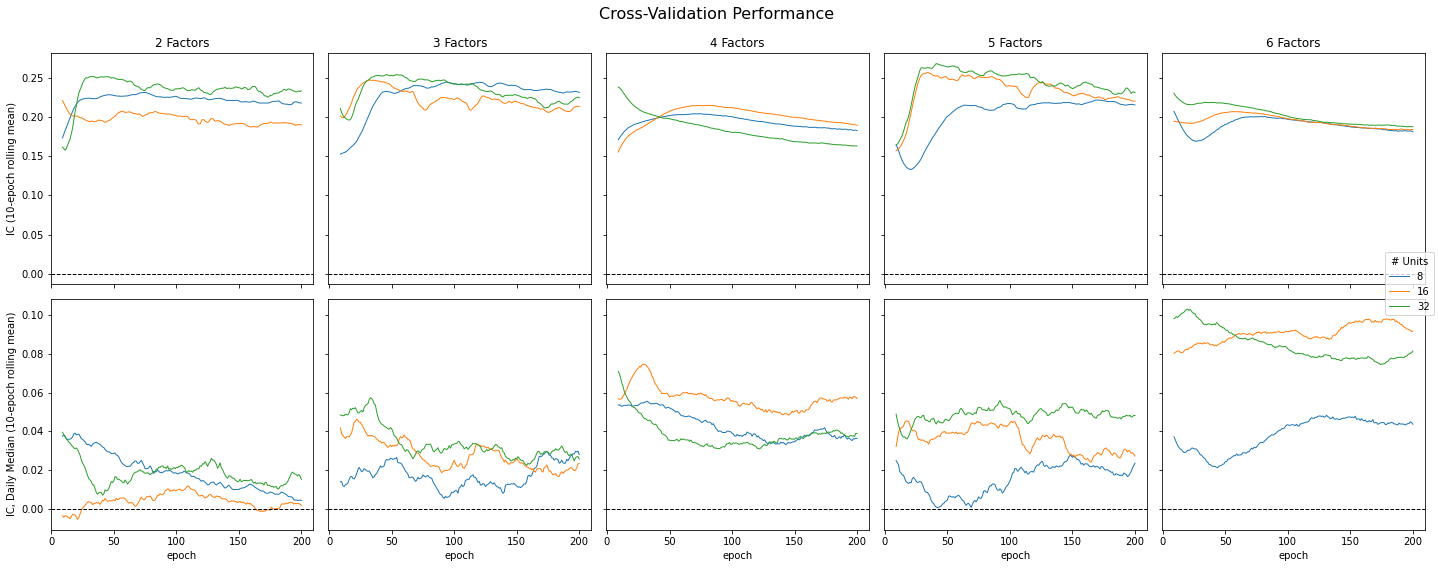

In [55]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9);